# Retail Store Demand Forecasting
 

Objective  
Explore historical retail store data and check how past sales and promotion signals relate to demand one week ahead.

Hypotheses  

- **Null hypothesis (H₀)**: Past sales and promotions do not add significant predictive signal for next week product demand.  
- **Alternative hypothesis (Hₐ)**: Past sales and promotions add significant predictive signal for next week product demand.


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


## Load Dataset

In [2]:
df = pd.read_csv("data/retail_store_inventory.csv")
print(df.head())

         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001    Groceries  North              231   
1  2022-01-02     S001      P0001    Groceries   West              116   
2  2022-01-03     S001      P0001  Electronics   West              154   
3  2022-01-04     S001      P0001    Groceries  South               85   
4  2022-01-05     S001      P0001    Groceries  South              238   

   Units Sold  Units Ordered  Price  Discount Weather Condition  \
0         127             55  33.50        20             Rainy   
1          81            104  27.95        10            Cloudy   
2           5            189  62.70        20             Rainy   
3          58            193  77.88        15            Cloudy   
4         147             37  28.46        20             Sunny   

   Holiday/Promotion  Competitor Pricing Seasonality  
0                  0               29.69      Autumn  
1                  0               30.89  

In [3]:
# Shape and info
print("Dataset shape:", df.shape)
print(df.info())

# Missing values
print(df.isnull().sum())

Dataset shape: (73100, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Price               73100 non-null  float64
 9   Discount            73100 non-null  int64  
 10  Weather Condition   73100 non-null  object 
 11  Holiday/Promotion   73100 non-null  int64  
 12  Competitor Pricing  73100 non-null  float64
 13  Seasonality         73100 non-null  object 
dtypes: float64(2), int64(5), object(7)
memory usage: 7.8+ MB
None
Date         

EDA

In [4]:
print(df.describe())

       Inventory Level    Units Sold  Units Ordered         Price  \
count     73100.000000  73100.000000   73100.000000  73100.000000   
mean        274.469877    136.464870     110.004473     55.135108   
std         129.949514    108.919406      52.277448     26.021945   
min          50.000000      0.000000      20.000000     10.000000   
25%         162.000000     49.000000      65.000000     32.650000   
50%         273.000000    107.000000     110.000000     55.050000   
75%         387.000000    203.000000     155.000000     77.860000   
max         500.000000    499.000000     200.000000    100.000000   

           Discount  Holiday/Promotion  Competitor Pricing  
count  73100.000000       73100.000000        73100.000000  
mean      10.009508           0.497305           55.146077  
std        7.083746           0.499996           26.191408  
min        0.000000           0.000000            5.030000  
25%        5.000000           0.000000           32.680000  
50%       10

## Target Distribution


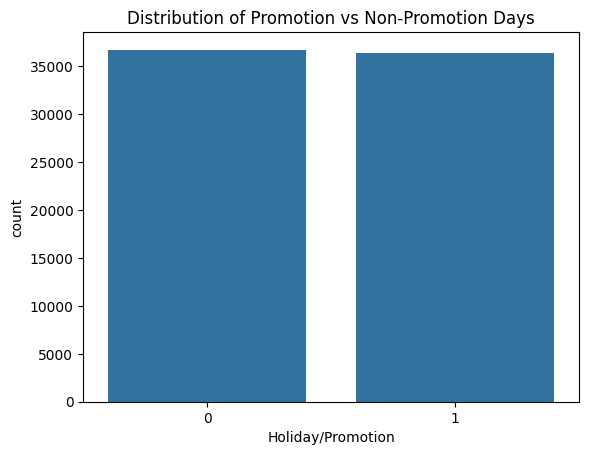

In [5]:
sns.countplot(x="Holiday/Promotion", data=df)
plt.title("Distribution of Promotion vs Non-Promotion Days")
plt.show()

## Correlation Heatmap

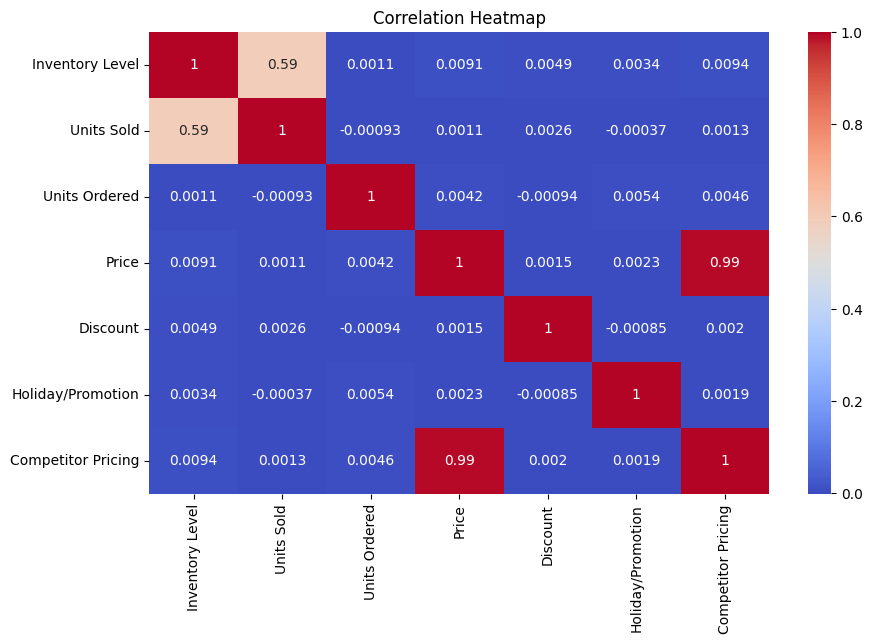

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

## Feature Exploration


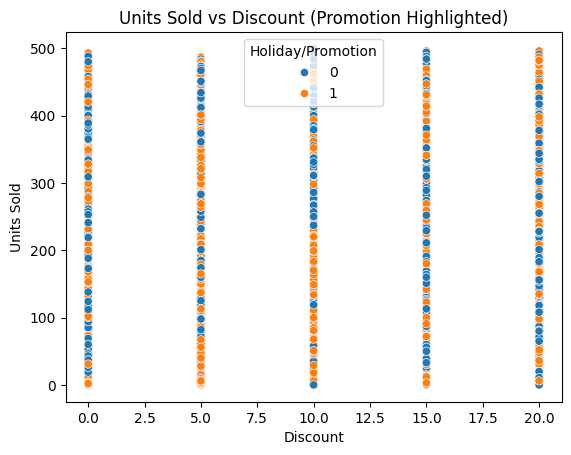

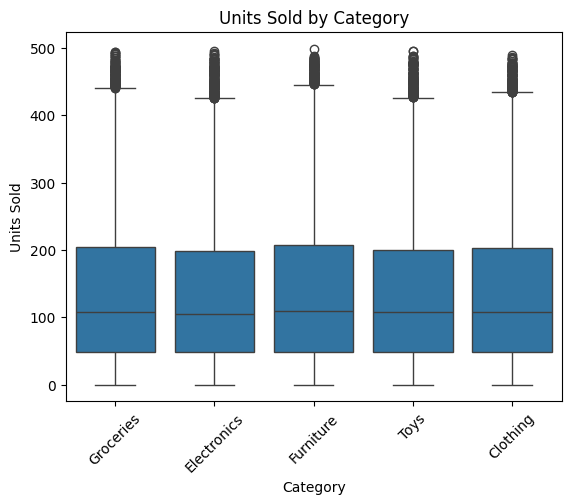

In [7]:
# Units Sold vs Discount
sns.scatterplot(x="Discount", y="Units Sold", hue="Holiday/Promotion", data=df)
plt.title("Units Sold vs Discount (Promotion Highlighted)")
plt.show()

# Category vs Units Sold
sns.boxplot(x="Category", y="Units Sold", data=df)
plt.title("Units Sold by Category")
plt.xticks(rotation=45)
plt.show()

## 1. Logistic Classification


In this part we are implementing Logistic classification in a way that directly supports our project’s purpose: predicting demand one week ahead based on past sales and promotion signals.

Instead of just predicting Holiday/Promotion, we’ll reframe the target to High vs. Low Demand. This best alligns with our hypothesis: past sales and promotions add predictive signal for next week’s demand.

For this to be done we'll begin by creating a binary target which is,

1 = High Demand (Units Sold > median)
0 = Low Demand (Units Sold ≤ median)




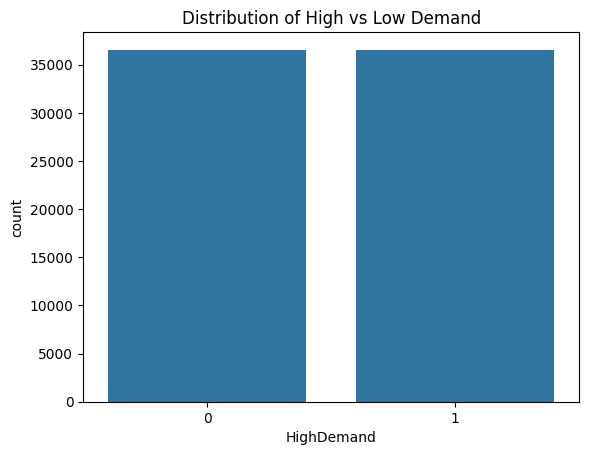

In [8]:
# Create binary target based on median Units Sold
median_units = df["Units Sold"].median()
df["HighDemand"] = (df["Units Sold"] > median_units).astype(int)

# Check distribution
sns.countplot(x="HighDemand", data=df)
plt.title("Distribution of High vs Low Demand")
plt.show()


To align with our term project objective, predicting demand one week ahead we reframed the classification task. Instead of predicting promotions, we created a new binary target called `HighDemand`, based on whether `Units Sold` is above the median value. This allows us to classify each record as either high demand (1) or low demand (0).

The bar chart above shows the distribution of this new target. As we can see, the dataset is well balanced, with nearly equal counts of high and low demand instances. This is ideal for logistic regression, as it avoids bias toward one class and ensures fair evaluation.



### Prepare Features

Now that we’ve defined a meaningful target, the next is to prepare the features in the sense,

-Drop irrelevant columns like `Date`, `Store ID`, `Product ID`, and `Units Sold`.  
-Encode categorical variables such as `Category`, `Region`, `Weather Condition`, and `Seasonality`  using one-hot encoding.

In [9]:
# Drop irrelevant columns
df_cleaned = df.drop(columns=["Date", "Store ID", "Product ID", "Units Sold"])

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Separate features and target
X = df_encoded.drop(columns=["HighDemand"])  # Features
y = df_encoded["HighDemand"]                 # Target

### Train-Test Split 

Our next step is to split the dataset into training and testing sets to evaluate model performance fairly.



In [10]:

# --- TRAIN-TEST SPLIT ---
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25,       # 25% of data for testing
    random_state=42,      # reproducibility
    stratify=y            # keep class distribution balanced
)

print("Training set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

# --- STANDARDIZE ALL FEATURES (INCLUDING CATEGORICAL) ---
from sklearn.preprocessing import StandardScaler

# Create and fit scaler ONLY on training data
scaler = StandardScaler()

# Fit on ALL training features (continuous + binary dummies)
scaler.fit(X_train)  # This learns mean and std for EVERY column

# Transform both sets using the SAME learned parameters
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames to maintain column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✓ ALL features standardized (mean=0, std=1 for every column)")
print("✓ Includes: Continuous features + Binary features + One-hot dummies")
print("✓ No data leakage - scaler fitted on training data only")

# Verify standardization
print("\nVerification - First 3 features of first training sample:")
for i, col in enumerate(X_train.columns[:3]):
    print(f"  {col}: {X_train.iloc[0, i]:.4f}")

Training set size: 54825
Testing set size: 18275
✓ ALL features standardized (mean=0, std=1 for every column)
✓ Includes: Continuous features + Binary features + One-hot dummies
✓ No data leakage - scaler fitted on training data only

Verification - First 3 features of first training sample:
  Inventory Level: 0.1033
  Units Ordered: 1.5701
  Price: 1.3309


## Logistic Regression Implementation
Now that we are all set to train the model and evaluate it, in this step we are going to 
- Train the model using the prepared features.  
- Evaluate using accuracy, precision, recall, and a confusion matrix


Accuracy: 0.7115731874145007

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71      9140
           1       0.71      0.71      0.71      9135

    accuracy                           0.71     18275
   macro avg       0.71      0.71      0.71     18275
weighted avg       0.71      0.71      0.71     18275



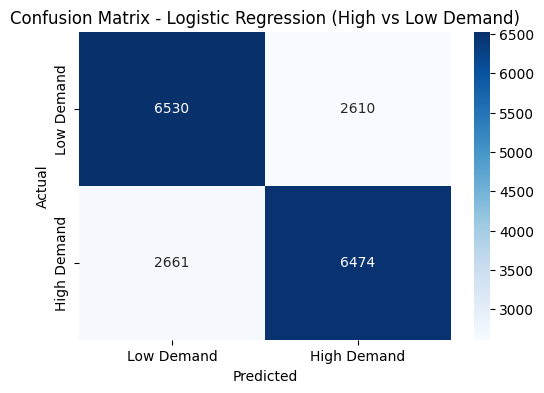

In [11]:
# Train Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(X_train, y_train)

# Predictions on test set
y_pred = log_reg.predict(X_test)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Low Demand","High Demand"], 
            yticklabels=["Low Demand","High Demand"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression (High vs Low Demand)")
plt.show()

                    Feature  Coefficient  AbsCoefficient
0           Inventory Level     1.180766        1.180766
17       Seasonality_Summer    -0.026081        0.026081
6      Category_Electronics    -0.017337        0.017337
16       Seasonality_Spring    -0.016419        0.016419
10             Region_North    -0.011661        0.011661
18       Seasonality_Winter    -0.009581        0.009581
3                  Discount     0.008960        0.008960
5        Competitor Pricing    -0.007657        0.007657
7        Category_Furniture    -0.007126        0.007126
1             Units Ordered    -0.006863        0.006863
8        Category_Groceries    -0.006587        0.006587
14  Weather Condition_Snowy    -0.005691        0.005691
2                     Price    -0.005522        0.005522
9             Category_Toys     0.004771        0.004771
4         Holiday/Promotion     0.004226        0.004226


C:\Users\Vishnu\AppData\Local\Temp\ipykernel_28400\1908103416.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y="Feature", data=coef_df_sorted.head(15), palette="coolwarm")


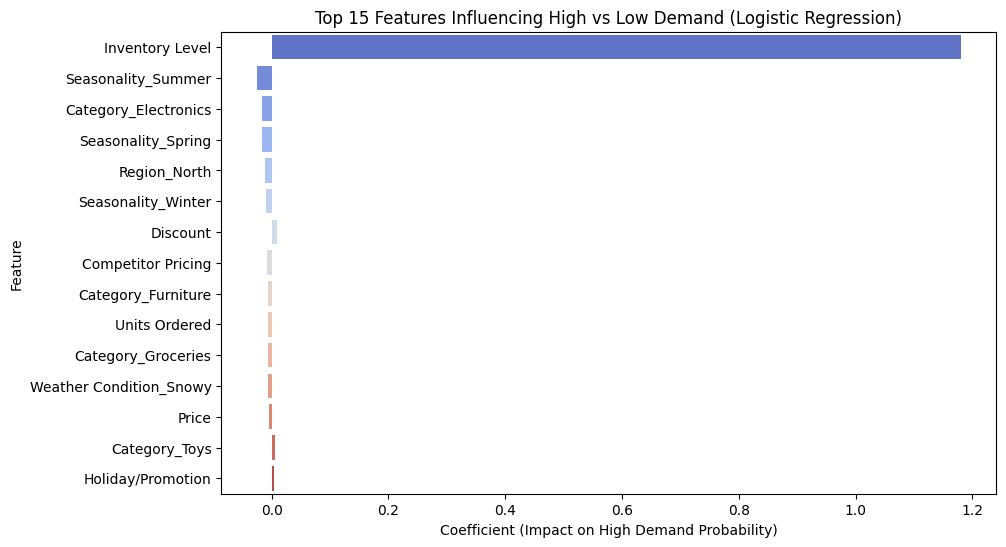

In [12]:
# Step 4: Feature Importance (Coefficients)

# Get feature names
feature_names = X_train.columns

# Extract coefficients from the trained logistic regression model
coefficients = log_reg.coef_[0]

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

# Sort by absolute value of coefficient (strongest impact first)
coef_df["AbsCoefficient"] = coef_df["Coefficient"].abs()
coef_df_sorted = coef_df.sort_values(by="AbsCoefficient", ascending=False)

# Display top 15 most influential features
print(coef_df_sorted.head(15))

# Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=coef_df_sorted.head(15), palette="coolwarm")
plt.title("Top 15 Features Influencing High vs Low Demand (Logistic Regression)")
plt.xlabel("Coefficient (Impact on High Demand Probability)")
plt.ylabel("Feature")
plt.show()
